# 문서요약 텍스트 EDA

In [1]:
import os
import json
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import zipfile

In [ ]:
def append_text(json_text, index, field):
    '''
    
    떨어져 있는 텍스트들을 하나의 문서로 합치는 함수
    
    ex. 법률 데이터라면, 
    
    판례 조항마다 "1. 텍스트", "2. 텍스트"로 나누어져 있어서 하나의 text로 합치는 함수
    
    '''
    tmp_text = ""
    if index!=0:
        tmp_text +="\n"
    
    for i in range(len(json_text)):
        if len(json_text)-1==i:
            tmp_text+=json_text[i]['sentence']
            break
        tmp_text+=json_text[i]['sentence']+" "
    return tmp_text

In [ ]:
def merge_json(path, field) :
    '''
    3개(법률, 신문기사, 사설잡지)의 데이터가 Training folder와 Validation folder 안에 
    2개의 json으로 나눠져 있어서 하나로 합치는 함수
    
    '''
    mj = []
    for dt in ['Training', 'Validation'] :
        dir_path = os.path.join(path, dt, field)
        files = os.listdir(dir_path)
        
        for file in files:
            file_path = os.path.join(dir_path, file)
            if dt == "Training":
                zip_file = zipfile.ZipFile(file_path).extract('train_original.json') 
            else:
                zip_file = zipfile.ZipFile(file_path).extract('valid_original.json')
            
            with open(zip_file, 'r') as f:
                d = json.load(f)
                name = d['name']
                delivery_date = d['delivery_date']
                
                # documents 갯수만큼 호출
                for i in range(len(d['documents'])):
                    tmp = d['documents'][i]
                    if tmp['title']=="null":
                        continue
                    
                    text = d['documents'][i]['text']
                    total_text=""
                    data = {"name":name, "delivery_date":delivery_date}
                    
                    for cc in tmp.keys():
                        if cc != "text":
                            data[cc]=tmp[cc]
                    
                    for c in range(len(text)):
                        tmp_text = append_text(text[c],c,field)
                        total_text+=tmp_text
                    
                    data["text"]=total_text
                    
                    mj.append(data)
            
    return mj

In [ ]:
def make_csv(mj, field):
    '''
    mj type: json, field type: string
    
    json 파일을 csv 및 bin 파일로 저장하는 함수
    '''
    df = pd.json_normalize(mj)
    df = df.drop_duplicates(['text'], ignore_index = True)
    path_csv = '/opt/ml/final_data/문서_요약_tsv/'+field+"/"
    path_csv = os.path.join(path_csv)
    with open(path_csv+'total_'+field+'.bin', 'wb') as f :
        pickle.dump(df, f)
    df.to_csv(path_csv+'total_'+field+'.csv', index=False)  
    print("complete!")

In [ ]:
def train_and_test_split(df, field):
    '''
    mj type: json, field type: string
    
    train과 test를 나눠서 csv 및 bin 파일로 저장하는 함수
    '''
    train, valid = train_test_split(df, test_size=0.2, random_state=1227)
    
    path_csv = '/opt/ml/final_data/문서_요약_tsv/'+field+"/"
    path_csv = os.path.join(path_csv)
    with open(path_csv+'train_'+field+'.bin', 'wb') as f :
        pickle.dump(train, f)
    train.to_csv(path_csv+'train_'+field+'.csv', index=False)  
    print("train data complete!")
    
    with open(path_csv+'valid_'+field+'.bin', 'wb') as f :
        pickle.dump(valid, f)
    valid.to_csv(path_csv+'valid_'+field+'.csv', index=False)
    print("valid data complete!")

## 0. 법률, 사설잡지, 신문기사 공통 column

**공통으로 존재하는 columns** 

**name**: field name (ex. 법률문서 프로젝트, 사설/잡지 문서 프로젝트, 문서요약 프로젝트)

**delivery_date**: 생성시간 (ex. 2020-12-23 17:23:13)

**id**: 문서 아이디 (ex. 119670)

**category**: 각 field 세부 카테고리 (ex. 일반행정) -> **이거 사용하게 될까?**

**size**: 본문 길이 (ex. small)

**char_count**: 본문 글자 수 (ex. 279)

**publish_date**: 게시시간

**title**: 제목 -> **무조건 사용!!!**

**annotator_id**: ex.3658

**extractive**: 추출된 문장 index

**abstractive**: 본문 생성 요약 text

**text**: 흩어진 text를 합쳐준 total text -> **무조건 사용!!!**

**document_quality_scores.readable**: 가독성 점수

**document_quality_scores.accurate**: 정확성 점수

**document_quality_scores.informative**: 정보성 점수

**document_quality_scores.trustworthy**: 신뢰성 점수

## 0-1. 전체 데이터 결측값 확인

* Nan 값 분포 표

|columns|법률|사설잡지|신문기사|
|------|---|---|---|
|title|11|0|0|
|text|0|0|0|
|category|1|525|0|

**우선 title이 없는 것은 확실한 결측값이 맞으니 제거 필요!**

In [8]:
df_law = pd.read_csv("final_data/문서_요약_tsv/법률/total_법률.tsv",delimiter='\t')
df_jabji = pd.read_csv("final_data/문서_요약_tsv/사설잡지/total_사설잡지.tsv",delimiter='\t')
df_paper = pd.read_csv("final_data/문서_요약_tsv/신문기사/total_신문기사.tsv",delimiter='\t')

print("법률 문서의 title이 null인 갯수 확인!: ",len(df_law[df_law['title'].isnull()]))
print("사설잡지 문서의 title이 null인 갯수 확인!: ",len(df_jabji[df_jabji['title'].isnull()]))
print("신문기사 문서의 title이 null인 갯수 확인!: ",len(df_paper[df_paper['title'].isnull()]))
print("================================")
print("법률 문서의 text가 null인 갯수 확인!: ",len(df_law[df_law['text'].isnull()]))
print("사설잡지 문서의 text가 null인 갯수 확인!: ",len(df_jabji[df_jabji['text'].isnull()]))
print("신문기사 문서의 text가 null인 갯수 확인!: ",len(df_paper[df_paper['text'].isnull()]))
print("================================")
print("법률 문서의 category가 null인 갯수 확인!: ",len(df_law[df_law['category'].isnull()]))
print("사설잡지 문서의 category가 null인 갯수 확인!: ",len(df_jabji[df_jabji['category'].isnull()]))
print("신문기사 문서의 category가 null인 갯수 확인!: ",len(df_paper[df_paper['category'].isnull()]))

법률 문서의 title이 null인 갯수 확인!:  11
사설잡지 문서의 title이 null인 갯수 확인!:  0
신문기사 문서의 title이 null인 갯수 확인!:  0
법률 문서의 text가 null인 갯수 확인!:  0
사설잡지 문서의 text가 null인 갯수 확인!:  0
신문기사 문서의 text가 null인 갯수 확인!:  0
법률 문서의 category가 null인 갯수 확인!:  1
사설잡지 문서의 category가 null인 갯수 확인!:  522
신문기사 문서의 category가 null인 갯수 확인!:  0


In [10]:
law_data = pd.read_csv("final_data/문서_요약_tsv/법률/train_법률.tsv",delimiter='\t')
jabji_data = pd.read_csv("final_data/문서_요약_tsv/사설잡지/train_사설잡지.tsv",delimiter='\t')
paper_data = pd.read_csv("final_data/문서_요약_tsv/신문기사/train_신문기사.tsv",delimiter='\t')
law_data_valid = pd.read_csv("final_data/문서_요약_tsv/법률/valid_법률.tsv",delimiter='\t')
jabji_data_valid = pd.read_csv("final_data/문서_요약_tsv/사설잡지/valid_사설잡지.tsv",delimiter='\t')
paper_data_valid = pd.read_csv("final_data/문서_요약_tsv/신문기사/valid_신문기사.tsv",delimiter='\t')

/opt/conda/envs/lightweight/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. 법률 데이터 EDA

## 1-1. 법률 Title의 특징 찾기 및 길이 분포

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


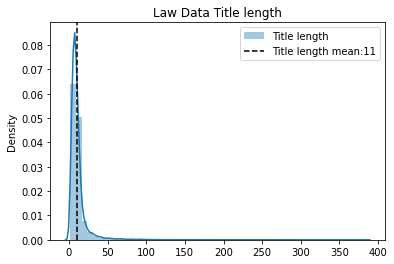

 가장 긴 title 길이는 384 길이를, 평균 title 길이는 11.408091024020228 길이를, 가장 짧은 title 길이는 1 길이를 가지고 있습니다.


In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title_length'])

tt['title_length'] = [len(i) for i in law_data['title']]
# index = tt[tt['title_length']==384].index
# tt.drop(index,inplace=True)

def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.title_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.title_length), hist=True, kde=True, label='Title length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Law Data Title length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 title 길이는 {tt['title_length'].max()} 길이를, 평균 title 길이는 {tt['title_length'].mean()} 길이를, 가장 짧은 title 길이는 {tt['title_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)

**중복되는 title 수가 너무 많다!**

In [12]:
d={}
for i in range(len(law_data)):
    if law_data.loc[i]['title'] not in d.keys():
        d[law_data.loc[i]['title']]=1
    else:
        d[law_data.loc[i]['title']]+=1
len(d)
d = sorted(d.items(), key = lambda item: item[1], reverse = True)
print(d[0:100])

[('손해배상(기)', 1170), ('소유권이전등기', 484), ('손해배상(자)', 358), ('거절사정', 321), ('양도소득세부과처분취소', 295), ('구상금', 291), ('손해배상', 258), ('소유권이전등기말소', 243), ('부가가치세부과처분취소', 240), ('부당이득금', 240), ('법인세등부과처분취소', 227), ('배당이의', 225), ('법인세부과처분취소', 217), ('부당이득금반환', 210), ('양도소득세등부과처분취소', 184), ('보험금', 177), ('취득세부과처분취소', 169), ('대여금', 156), ('퇴직금', 128), ('종합소득세부과처분취소', 125), ('채무부존재확인', 122), ('증여세부과처분취소', 121), ('취득세등부과처분취소', 112), ('등록무효(상)', 107), ('상표등록무효', 107), ('임금', 101), ('거절사정(상)', 99), ('토지수용재결처분취소', 97), ('해고무효확인등', 95), ('손해배상청구사건', 91), ('증여세등부과처분취소', 89), ('소유권이전등기말소등', 88), ('약속어음금', 85), ('종합소득세등부과처분취소', 83), ('사기', 83), ('택지초과소유부담금부과처분취소', 78), ('건물명도', 77), ('상속세부과처분취소', 77), ('해고무효확인', 76), ('개발부담금부과처분취소', 76), ('양수금', 76), ('부당해고구제재심판정취소', 75), ('소유권이전등기등', 75), ('토지소유권이전등기', 73), ('권리범위확인', 72), ('전부금', 72), ('보증채무금', 70), ('손해배상(의)', 65), ('사해행위취소', 65), ('부당노동행위구제재심판정취소', 64), ('공직선거및선거부정방지법위반', 64), ('건물철거등', 62), ('거절결정(상)', 61), ('폭력행위등처벌에관한법률위반', 60), ('교통사고처리특례법위반', 60), ('

## 1-2. 법률 text 특징 찾기 및 길이 분포

* 법률 text 특징

[1], [2]로 시작하거나, '가.', '나.' 등으로 나열되어 있는 text가 많음!

In [15]:
law_data.loc[400]['text']

'[ 다수의견 ]\n가. 택지소유상한에관한법률 시행 당시 보유하고 있던 가구별 소유상한을 초과하는 택지나 법인 소유 택지가 택지초과소유부담금 부과대상에서 제외되기 위한 사유인 이용·개발 역시 같은 법 제11조 제1항, 제12조 제1항 각 호에 해당하는 내용으로의 이용·개발이어야 하는 것이고, 이와 같은 내용으로 이용·개발하지 아니하고 법 시행 당시의 이용방법에 따라 계속 이용하는 경우에는 택지초과소유부담금 부과대상에서 제외되지 아니하는 것이다.\n나. 자동차 운전학원 실기교습장 부지로서의 택지 이용이 택지소유상한에관한법률 제11조 제1항 각 호에 해당하는 것인지 여부를 검토함이 없이 법 시행 전에 사용하던 용도대로 계속 이용하겠다는 사용계획서를 제출하고 그대로 이용하고 있다는 사정만으로 택지초과소유부담금 부과 제외 택지에 해당하는 것으로 본 원심판결에는 택지초과소유부담금 부과대상에서 제외되는 택지의 범위에 관한 법리오해의 위법이 있다.\n[ 소수의견 ]\n가. 구 택지소유상한에관한법률시행령(1990.3.2. 대통령령 제12935호) 부칙 제3조 제1항에서 택지소유상한에관한법률 제10조 내지 제15조의 규정에 의한 사용계획서를 제출한 택지로서 당해 사용계획서대로 택지를 이용·개발한 경우에 택지초과소유부담금을 부과하지 아니하도록 한 입법취지는 법 시행 이전부터 택지를 소유하고 있는 국민의 기득재산권의 보장과 법이 추구하는 목적달성의 조화를 꾀하려는 데 있는 것으로 보아야 할 것이므로, 위 규정에 따라 택지초과소유부담금 부과대상이 되지 아니하는 택지의 범위를 정함에 있어서는 위와 같은 법의 입법취지를 고려하여 당해 택지에 대하여 택지초과소유부담금을 부과할 것인지 여부를 구체적으로 따져 보아야 할 것이고, 특히 기존의 택지 소유자가 법 시행 이전에 다른 법령에 의하여 소유가 강제되기 때문에 보유하고 있던 택지에 대하여 택지초과소유부담금을 부과할 것인지 여부를 가리기 위하여는 법의 입법목적 이외에도 그 관계 법령의 입법취지를 종합하여 판별기준으로 삼지 않을 수 없는 것

In [17]:
law_data.loc[2000]['text']

'[1] 부집행의 합의는 실체상의 청구의 실현에 관련하여 이루어지는 사법상의 채권계약이라고 봄이 상당하고, 이것에 위반하는 집행은 실체상 부당한 집행이라고 할 수 있으므로 민사소송법 제505조가 유추적용 내지 준용되어 청구이의의 사유가 된다.\n[2] 국립과학수사연구소가 수사기관으로부터 약정서의 필적에 관한 감정을 의뢰받아 관계자들의 시필을 채취하여 감정한 결과 그 작성 명의인의 서명필적은 그의 실제 필적과 동일성이 인정되어 이를 회보한다는 내용의 감정의뢰 회보는, 진정성립이 추정되는 공문서이므로 별도의 신빙성 있는 반대 자료가 없는 한 이를 배척하고 그 기재와 어긋나는 사실인정을 할 수는 없다.'

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


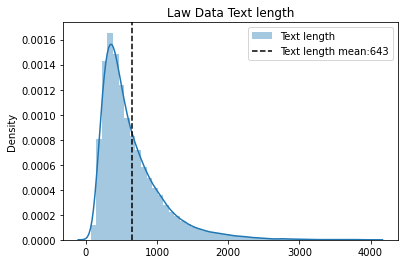

 가장 긴 text 길이는 3993 길이를, 평균 text 길이는 643.0092288242731 길이를, 가장 짧은 text 길이는 67 길이를 가지고 있습니다.


In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['text_length'])

tt['text_length'] = [len(i) for i in law_data['text']]

def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.text_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.text_length), hist=True, kde=True, label='Text length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Text length mean:{max_seq_len}')
    plt.title('Law Data Text length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 text 길이는 {tt['text_length'].max()} 길이를, 평균 text 길이는 {tt['text_length'].mean()} 길이를, 가장 짧은 text 길이는 {tt['text_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)

In [14]:
co = 0
over_two=[]
for i in range(len(law_data)):
    if len(law_data.loc[i]['text'])>=2000:
        co+=1
        over_two.append(i)
print("법 text 길이가 2000이 넘는 갯수: ",co)
print("법 text 길이 2000이 넘는 데이터 비율: ",(co/len(law_data))*100)

법 text 길이가 2000이 넘는 갯수:  420
법 text 길이 2000이 넘는 데이터 비율:  1.7699115044247788


## 2. 사설잡지 데이터 EDA

## 2-1. 사설잡지 Title의 특징 찾기 및 길이 분포

* 사설잡지 title 특징


**대부분 앞에 "[~~] ~~" 이 들어간다!**

ex. [책갈피] 미국 권력층 해부에 일생을 바치다, [신간] 탄실, [정밀분석] 정치권 빅뱅 불러올 ‘플랜B’ 大해부

In [23]:
df_jabji.loc[1000]['title']

'[사설] 100일 남은 한국대선, 미국과 비교해보면'

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


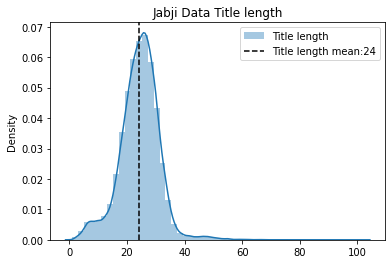

 가장 긴 title 길이는 102 길이를, 평균 title 길이는 24.405723937674367 길이를, 가장 짧은 title 길이는 1 길이를 가지고 있습니다.


In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title_length'])

tt['title_length'] = [len(i) for i in jabji_data['title']]

def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.title_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.title_length), hist=True, kde=True, label='Title length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Jabji Data Title length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 title 길이는 {tt['title_length'].max()} 길이를, 평균 title 길이는 {tt['title_length'].mean()} 길이를, 가장 짧은 title 길이는 {tt['title_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)

## 2-2. 사설잡지 text 특징 찾기 및 길이 분포

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


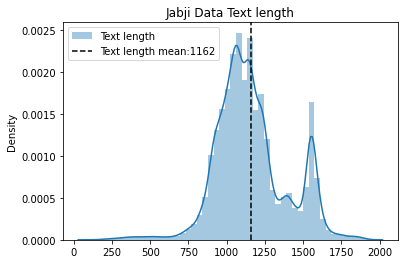

 가장 긴 text 길이는 1939 길이를, 평균 text 길이는 1161.5736463532671 길이를, 가장 짧은 text 길이는 109 길이를 가지고 있습니다.


In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['text_length'])

tt['text_length'] = [len(i) for i in jabji_data['text']]

def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.text_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.text_length), hist=True, kde=True, label='Text length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Text length mean:{max_seq_len}')
    plt.title('Jabji Data Text length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 text 길이는 {tt['text_length'].max()} 길이를, 평균 text 길이는 {tt['text_length'].mean()} 길이를, 가장 짧은 text 길이는 {tt['text_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)

## 3. 신문기사 데이터 EDA

## 3-1. 신문기사 Title의 특징 찾기 및 길이 분포

Title 길이 최대 최소가 많이 차이남!

**title text에 title text + document text가 같이 있는 경우가 존재 -> 제거 한 뒤, EDA**

아래는 그 예시 중 한 개이다!

'송전선로 건설 면민 하나 돼 막아내자!”\t석문면 송전선로 건설 관련 새 대책위 출범 \\r\\n호명도·조권형 씨 공동대책위원장으로 선임 \\r\\n\\r\\n▲ 석문면 송전선로 건설 논란으로 지난 18일 새로운 대책위원회가 정기총회를 열고 공식 출범했다.\\r\\n\\r\\n석문면 송전선로 건설 논란과 관련해 새로운 대책위원회가 출범했다. 송전선로대책위원회는 지난 18일 석문문화스포츠센터에서 정관 제정 및 집행부 구성을 위한 정기총회를 열고, 송전선로 건설 문제에 대한 대응 방안을 논의했다. 이날 정기총회에서는 호명도·조권형 씨를 송전선로 공동대책위원장으로 선출했다.\\r\\n\\r\\n특히 주민들은 그동안 관련 문제 등으로 인해 면민들의 반목과 갈등이 깊어져 왔지만, 앞으로는 송전선로 백지화를 이뤄낼 수 있도록 주민들이 소통하면서 함께 힘을 모아야 한다는 것에 뜻을 모았다.\\r\\n\\r\\n대책위는 “성숙한 주민의식으로 새로운 대책위를 구성, 첫 걸음을 떼었다”며 “한마음 한 뜻으로 지역의 송전선로 문제를 해결해 나가는 데 함께 노력하자”고 밝혔다.\\r\\n\\r\\n한편 지난 2015년 석문면개발위원회(위원장 인나환)을 중심으로 구성된 석문면 송전선로 반대 대책위원회가 당진화력-신송산 간 345kV 송전선로 추가 건설 문제를 두고 한국전력과 노선 협의 등을 진행해 온 것이 뒤늦게 알려지면서 지역주민들의 거센 반발이 이어졌다.\\r\\n\\r\\n이에 기존 대책위는 지난 6월 그동안 한국전력과의 협의된 모든 사항을 전면 백지화 하겠다고 밝히면 해체를 선언한 바 있다.\\r\\n\\r\\n더불어 석문면이장단협의회(회장 김우규)는 지난 20일 석문면개발위원회에 혁신 요구안을 제출했다. 10개 사항을 제시한 이번 요구안에는 △개발위원회 임원은 연관사업에 참여하지 않을 것 △사무국장 제도를 없애고 직원급여를 현실화 할 것 △플라이애쉬(석탄회) 사업자 선정은 석문면개발위원회 정기총회에서 결정할 것 △개발위원장 선거에는 석문면에 거주한 지 10년 이상인 면민에게 출마 기회를 줄 것 △전직 개발위원장은 선거권을 부여하지 말 것 △술과 개인숙박 등 개발위원회 업무추진비 사용을 자제하고 카드 사용내역을 공개할 것 △투명한 회계처리를 위해 외부감사제도를 도입할 것 △석문면개발위원회 사단법인 등기에 기재된 현 등기이사는 무효이므로 제명할 것 △석문면이장단협의회, 석문면개발위원회 고문 및 자문위원에게 지역신문사를 통해 공개사과하며, 개발위원회의 혁신 요구안을 관철하고 입장을 표명할 것 등을 주장했다.\\r\\n\\r\\n임아연  zelkova87@hanmail.net\\r\\n\r\n312226305\t당진시대\t온라인\t지역지\t2018-07-22 22:27:00\t사회\t중\t1198\t라돈 매트리스, 당진서 해체\t반입 한 달 만에 현장서 해체키로 결정\\r\\n방사선 수치 공개·현장 모니터링 등 실시\\r\\n23일부터 작업 시작…열흘 소요 예상\\r\\n송악읍 한진리 주민들 반대집회 나서 \\r\\n라돈이 과다 검출된 대진침대 매트리스가 당진에 반입된 지 한 달 만에 송악읍 고대리 주민들의 주민총회를 거쳐 당진 야적장 현장에서 해체키로 결정됐다. 매트리스 해체작업은 23일부터 시작되며 해체가 완료되기까지는 열흘 가량 소요될 것으로 예상되고 있다.\\r\\n\\r\\n앞서 지난달 16일 송악읍 고대리에 위치한 동부당진항만 야적장에 1만7000여 개에 이르는 ‘라돈 매트리스’가 반입됐다. 뒤늦게 이 사실을 안 주민들은 현장에서 추가 반입을 저지하며 집회를 열고 매트리스를 타 지역으로 옮길 것을 강력히 요구했다. <본지 제1213호 ‘방사능 피복 라돈침해 일파만파’ 기사 참고>\\r\\n\\r\\n한편 문제가 발생한 지 한 달 여 만인 지난 17일 송악읍 고대리 주민들은 주민총회를 열고 현장에서 해체하는 것에 동의했다.\\r\\n\\r\\n고대1리 마을회관에서 열린 마을 총회에는 마을 주민을 비롯해 김홍장 당진시장과 홍남기 청와대 국무조정실장, 강정민 원자력안전위원장 등이 참석했다.\\r\\n\\r\\n현장에서 홍남기 국무조정실장은 당진에 라돈 매트리스를 반입하는 과정에서 주민의 이해를 구하지 못한 절차에 대해 사과했으며 해체 과정에 있어 안정성 문제를 다시 한 번 설명하며 주민들을 설득했다.\\r\\n\\r\\n이후 김홍장 시장과 주민 간의 논의 과정을 거친 뒤 당진동무항만 야적장에서 해체하는 것에 동의했으며, 철저한 환경·안전 관리를 당부했다.\\r\\n\\r\\n한편 정부에서는 매트리스 해체작업 시 직접 방사선 안전관리를 수행하겠다고 밝혔다. 천안과 당진에 각각 4명(원자력안전위원회 2명·한국원자력안전기술원 2명)이 현장에 상주하며 작업장 방사선 환경감시와 종사자 안전관리 등을 점검키로 했다.\\r\\n\\r\\n또한 원안위 측에서는 주민들의 우려를 해소하고자 주민이 요구할 경우 해체 작업 과정을 직접 확인할 수 있도록 방안을 마련하겠다고 밝혔다. 이에 야적장 인근에 학교(상록초)가 위치해 있어 걱정의 목소리를 높였던 학부모 측에서도 해체 작업을 참관하겠다는 입장을 밝혔다. 또한 방사선 수치도 수시로 공개할 방침이다.\\r\\n\\r\\n한편 이번 고대리 주민총회를 거쳐 해체 작업이 당진에서 이뤄지는 것과 관련해 송악읍 한진리 주민들은 지난 18일부터 반대 집회에 나서 또 다른 갈등으로 번지고 있다.\\r\\n \\r\\n\\r\\n한수미  d911112@naver.com\\r\\n\r\n312226307\t당진시대\t온라인\t지역지\t2018-07-22 22:27:00\t사회\t소\t870\t“당진시·의회 업무추진비 조례 제정해야'

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


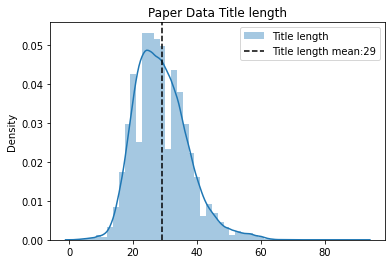

 가장 긴 title 길이는 92 길이를, 평균 title 길이는 28.873996376149076 길이를, 가장 짧은 title 길이는 1 길이를 가지고 있습니다.


In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title_length'])

tt['title_length'] = [len(i) for i in paper_data['title']]
def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.title_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.title_length), hist=True, kde=True, label='Title length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Paper Data Title length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 title 길이는 {tt['title_length'].max()} 길이를, 평균 title 길이는 {tt['title_length'].mean()} 길이를, 가장 짧은 title 길이는 {tt['title_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)

## 3-2. 신문기사 text 특징 찾기 및 길이 분포

### **text길이 14794 데이터 제거!**

**신문기사 text 특징: 앞이나 뒤에 종종, 메일이 남겨져 있는 경우가 꽤 존재**

In [41]:
paper_data.loc[3000]['text']

'전남의 구급차 도착시간이 늦어 심정지 환자의 소생률도 낮은 것으로 파악됐다.\n10일 국회 행정안전위원회 더불어민주당 소병훈 의원(경기 광주시갑)이 소방청으로 부터 제출받은 최근 5년간 심폐소생 이송인원 대비 소생인원을 보면, 총 15만1천154명 중 6.6%인 9천957명이 소생하고 93.4%인 14만1천197명이 사망했다.\n전남은 2014년 1천657명의 심정지 환자가 이송돼 21명이 생존했으며 2015년은 1천677명이 이송돼 60명만 생존했다. 2016년은 1천573명 중 44명, 2017년은 1천593명 중 59명, 지난 해는 1천538명 중 77명만 소생하는 등 전체 8천38명의 심정지로 인한 이송 환자 중 350명만 소생했다.\n이에 비해 광주는 2014년 660명의 심정지 환자가 이송돼 29명이 생존했으며 2015년은 670명이 이송돼 40명만 생존했다. 2016년은 637명 중 73명, 2017년은 626명 중 87명, 지난 해는 572명 중 79명만 소생하는 등 전체 3천174명의 심정지로 인한 이송 환자 중 308명이 소생했다.\n지역별 소생률을 보면, 광주가 9.7%로 전국에서 가장 높았으며 전남이 전국에서 가장 낮은 3.2%를 보여 3배의 편차를 보였다. 전국평균 6.6%보다 소생률이 낮은 지역은 전남 3.2%, 경북 4.1%, 충북 4.3%, 강원 4.4%, 전북과 경남·제주가 각각 5.1%, 대전이 5.8%순이었다.\n지역별 소생률의 편차가 지역별 구급차 현장도착시간과 밀접하다. 지난 해 지역별 구급차 현장 도착시간이 늦은 순으로 보면, 전남·경북·충북·전북(각각 10분), 강원·경남(9분)으로 대부분 소생률이 낮은 지역과 일치한다.\n연령별로는 10세 이하의 소생률이 3.3%로 전국 평균의 절반 이하에 불과해 총2천124명중 70명만이 목숨을 건졌다. 10세 이하 지역별 소생률을 보면 충북·경남이 1.3%로 가장 낮았으며, 전북 1.5%, 부산 1.6%, 대전 1.7%로 뒤를 이었다. 세종과 충남은 각각 9.1%와 8.4%로 상

/opt/conda/envs/lightweight/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


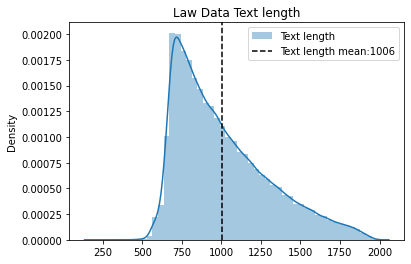

 가장 긴 text 길이는 1985 길이를, 평균 text 길이는 1006.4438261548947 길이를, 가장 짧은 text 길이는 210 길이를 가지고 있습니다.


In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['text_length'])

tt['text_length'] = [len(i) for i in paper_data['text']]

def plot_title_length(dataframe):
    max_seq_len = np.round(dataframe.text_length.mean()).astype(int)
    sns.distplot(tuple(dataframe.text_length), hist=True, kde=True, label='Text length')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Text length mean:{max_seq_len}')
    plt.title('Law Data Text length')
    plt.legend()
    plt.show()
    print(f" 가장 긴 text 길이는 {tt['text_length'].max()} 길이를, 평균 text 길이는 {tt['text_length'].mean()} 길이를, 가장 짧은 text 길이는 {tt['text_length'].min()} 길이를 가지고 있습니다.")
plot_title_length(tt)